Text classification for Fake News Detection


In [1]:
#%pip install nltk

In [2]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path, encoding = 'utf8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))
    return raw_data

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))
    return (train_data, test_data)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }

    #print(labels_map)
    return labels_map[label]
#print(labels_map)

def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    #label1 = [train_data, ]
    get_label = data_line[1]
    get_classification_label = convert_label(get_label)
    statement = data_line[2]
    # e.g. (label, statement)
    return (get_classification_label, statement)

In [5]:

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    token_list = text.split(' ')
    return token_list

In [6]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    feature_dict = {}
    keys = set(tokens)
    for key in keys:
        count = 0
        for token in tokens:
            if key==token:
                count = count+1
        feature_dict[key] = count
    return feature_dict

In [7]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [9]:

from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    train_fold_list = []
    
    #Recording precision, recall, fscore and accuracy for 10 folds (i.e. each training and validation data combintation)
    precision_list = []
    recall_list = []
    fscore_list = []
    accuracy_list = []
    
    #Creating folds
    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        fold_limit = i+int(fold_size)
        train_fold_list.append(dataset[i:fold_limit])
    
    #Generating training and validation datasets from the training dataset
    for validation_index in range(len(train_fold_list)):
        validation_dataset = train_fold_list[validation_index]
        train_dataset = []
        for train_index in range(len(train_fold_list)):
            if(train_index == validation_index):
                continue
            else:
                train_dataset.extend(train_fold_list[train_index])
        
#         print("Fold {}".format(validation_index))
#         print("Train subset length = {}".format(len(train_data)))
#         print("Validation data length = {}".format(len(validation_data)))
#         print()
        
        #training and validating the model for each train and validation combination and finally getting
        #new precision, recall, fscore and accuracy
        train_val_classifier = train_classifier(train_dataset)
        valid_true = [v[1] for v in validation_dataset]
        valid_pred = predict_labels([v[0] for v in validation_dataset], train_val_classifier)
        cv_scores = precision_recall_fscore_support(valid_true, valid_pred, average='weighted')
        compare_results = [1 if vt==vp else 0 for vt,vp in zip(valid_true,valid_pred)]
        accuracy_score = sum(compare_results)/len(compare_results)
        
        #Appending the the results to the list
        precision_list.append(cv_scores[0])
        recall_list.append(cv_scores[1])
        fscore_list.append(cv_scores[2])
        accuracy_list.append(accuracy_score)
    
    #Computing the average for each score
    avg_precision = round((sum(precision_list)/len(precision_list))*100,2)
    avg_recall = round((sum(recall_list)/len(recall_list))*100,2)
    avg_fscore = round((sum(fscore_list)/len(fscore_list))*100,2)
    avg_accuracy = round((sum(accuracy_list)/len(accuracy_list))*100,2)
    
    cv_result = [avg_precision,avg_recall,avg_fscore,avg_accuracy]
    #Returning the list of avg scores
    print("\nAverage Precision: {}\nAverage Recall: {}\nAverage F-score: {}\nAverage Accuracy: {}".format(avg_precision,
                                                                                                       avg_recall,
                                                                                                       avg_fscore,
                                                                                                       avg_accuracy)) 

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
0


In [11]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Fold start on items 820 - 1640
Fold start on items 1640 - 2460
Fold start on items 2460 - 3280
Fold start on items 3280 - 4100
Fold start on items 4100 - 4920
Fold start on items 4920 - 5740
Fold start on items 5740 - 6560
Fold start on items 6560 - 7380
Fold start on items 7380 - 8200
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...

Average Precision: 56.95
Average Recall: 56.95
Average F-score: 56.91
Average Accuracy: 56.95


In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty

def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [13]:
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    #return cm

Training Classifier...


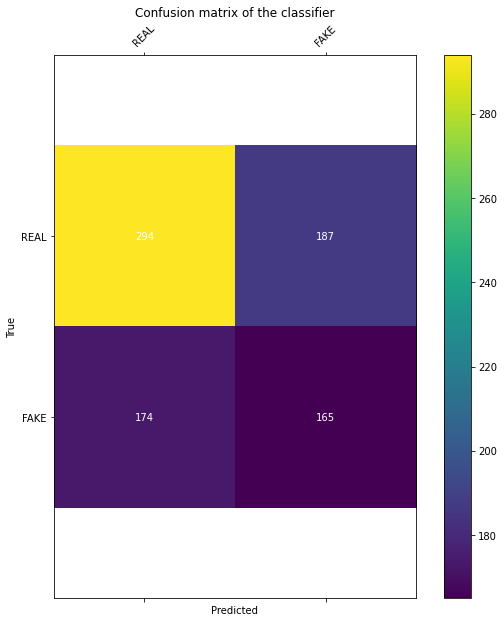

In [14]:
fold_size = int(len(train_data)/10)+1
valid_dataset = train_data[:fold_size]
train_dataset = train_data[fold_size:]

train_val_classifier = train_classifier(train_dataset)
valid_true = [v[1] for v in valid_dataset]
valid_pred = predict_labels([v[0] for v in valid_dataset], train_val_classifier)

confusion_matrix_heatmap(valid_true,valid_pred,["REAL","FAKE"])

In [15]:
valid_data = [v[0] for v in valid_dataset]
fp_data_list = []
fn_data_list = []
for i,j,k in zip(valid_true,valid_pred,valid_data):
    if(i!=j):
        if(i=="REAL"):
            fn_data_list.append([k,j,i])
        else:
            fp_data_list.append([k,j,i])

In [16]:
fp_data_list

[[{'district': 1,
   'Jim': 1,
   'in': 1,
   'not': 1,
   'lived': 1,
   'the': 1,
   'years': 1,
   'represents': 1,
   'for': 1,
   'now.': 1,
   'Dunnam': 1,
   'has': 1,
   'he': 1},
  'REAL',
  'FAKE'],
 [{'Massachusetts,': 1,
   'governor': 1,
   'cut': 1,
   'the': 1,
   'rate': 1,
   'it.': 1,
   'Mitt': 1,
   'growth': 1,
   'of': 3,
   'was': 1,
   'When': 1,
   'actually': 1,
   'our': 1,
   'slow': 1,
   'we': 2,
   'just': 1,
   'didnt': 1,
   'Romney': 1,
   'government,': 1},
  'REAL',
  'FAKE'],
 [{'some': 1,
   'of': 1,
   'sense': 1,
   'Most': 1,
   'otherwise': 1,
   'in': 1,
   'been': 1,
   'the': 1,
   '(Affordable': 1,
   'Care': 1,
   'Act)': 1,
   'already': 1,
   'or': 1,
   'suspended.': 1,
   'waived': 1,
   'has': 1},
  'REAL',
  'FAKE'],
 [{'work,': 1,
   'and': 1,
   'they': 2,
   'you': 1,
   'not': 1,
   'constantly': 1,
   'right': 1,
   'states': 1,
   'deficits': 1,
   'look': 1,
   'do': 1,
   'that': 1,
   'If': 1,
   'budget': 1,
   'climates.':

In [17]:
tn = 0
tp = 0
fp = 0
fn = 0
for i,j in zip(valid_true,valid_pred):
    if(i==j):
        if(i=="REAL"):
            tp = tp+1
        else:
            tn = tn+1
    else:
        if(i=="REAL"):
            fn = fn+1
        else:
            fp = fp+1
print("True Positive",tp)
print("True Negative",tn)
print("False Positive",fp)
print("False Negative",fn)

True Positive 294
True Negative 165
False Positive 174
False Negative 187


In [18]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ziyad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ziyad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import re
import nltk
from nltk.util import trigrams
from nltk.stem.porter import *
stemmer = PorterStemmer()

#for improving the performance, stemming is not helpful as it dosent use context which adds addtional information.
#for s1 in str1:
#        x1+=stemmer.stem(s1)+" "

def pre_process(text):
    # Should return a list of tokens
    #removing punctuation
    txt1=re.sub('[^ a-zA-Z0-9$!?\'\"\.]','',text)#replacing all special characters except few $,?,!,',"
    
    #removing stop words
    tokens=txt1.split(' ')
    str1 = [w for w in tokens if not w.lower() in stop_words]
    x1=''
    #Not using stemming to convert words as stemming is used when context is not important
    #Lemmatization is used instead as context is important here.
    
    #Lemmatization of words
    for s1 in str1:
        x1+=lemmatizer.lemmatize(s1)+" "
    #Tokenising words into bigrams
    nltk_tokens = nltk.word_tokenize(x1)
    tokens=list(nltk.bigrams(nltk_tokens))
    tokens1=[]
    for t1 in tokens:
        tokens1.append(str(t1[0])+" "+str(t1[1]))
    return tokens1



In [20]:
def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
         test_data.append((to_feature_vector(pre_process(text)),label))
    return (train_data, test_data)
    

In [21]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(C=0.1,class_weight="balanced"))])
    return SklearnClassifier(pipeline).train(data)

# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [22]:
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


data_file_path =r"fake_news.tsv"
load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), sep='\n')

Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192


In [23]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    train_fold_list = []
    
    #Recording precision, recall, fscore and accuracy for 10 folds (i.e. each training and validation data combintation)
    precision_list = []
    recall_list = []
    fscore_list = []
    accuracy_list = []
    
    #Creating folds
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        fold_limit = i+int(fold_size)
        train_fold_list.append(dataset[i:fold_limit])
        # FILL IN THE METHOD HERE
    
    #Generating training and validation datasets from the training dataset
    for validation_index in range(len(train_fold_list)):
        validation_dataset = train_fold_list[validation_index]
        train_dataset = []
        for train_index in range(len(train_fold_list)):
            if(train_index == validation_index):
                continue
            else:
                train_dataset.extend(train_fold_list[train_index])
        
#         print("Fold {}".format(validation_index))
#         print("Train subset length = {}".format(len(train_data)))
#         print("Validation data length = {}".format(len(validation_data)))
#         print()
        
        #training and validating the model for each train and validation combination and finally getting
        #new precision, recall, fscore and accuracy
        train_val_classifier = train_classifier(train_dataset)
        valid_true = [v[1] for v in validation_dataset]
        valid_pred = predict_labels([v[0] for v in validation_dataset], train_val_classifier)
        cv_scores = precision_recall_fscore_support(valid_true, valid_pred, average='weighted')
        compare_results = [1 if vt==vp else 0 for vt,vp in zip(valid_true,valid_pred)]
        accuracy_score = sum(compare_results)/len(compare_results)
        
        #Appending the the results to the list
        precision_list.append(cv_scores[0])
        recall_list.append(cv_scores[1])
        fscore_list.append(cv_scores[2])
        accuracy_list.append(accuracy_score)
    
    #Computing the average for each score
    avg_precision = round((sum(precision_list)/len(precision_list))*100,2)
    avg_recall = round((sum(recall_list)/len(recall_list))*100,2)
    avg_fscore = round((sum(fscore_list)/len(fscore_list))*100,2)
    avg_accuracy = round((sum(accuracy_list)/len(accuracy_list))*100,2)
    
    cv_result = [avg_precision,avg_recall,avg_fscore,avg_accuracy]
    #Returning the list of avg scores
    print("\nAverage Precision: {}\nAverage Recall: {}\nAverage F-score: {}\nAverage Accuracy: {}".format(avg_precision,
                                                                                                       avg_recall,
                                                                                                       avg_fscore,
                                                                                                       avg_accuracy)) 

In [24]:
cross_validate(train_data, 10)

Fold start on items 0 - 820
Fold start on items 820 - 1640
Fold start on items 1640 - 2460
Fold start on items 2460 - 3280
Fold start on items 3280 - 4100
Fold start on items 4100 - 4920
Fold start on items 4920 - 5740
Fold start on items 5740 - 6560
Fold start on items 6560 - 7380
Fold start on items 7380 - 8200
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...

Average Precision: 57.67
Average Recall: 58.1
Average F-score: 57.71
Average Accuracy: 58.1


In [25]:
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    #return cm

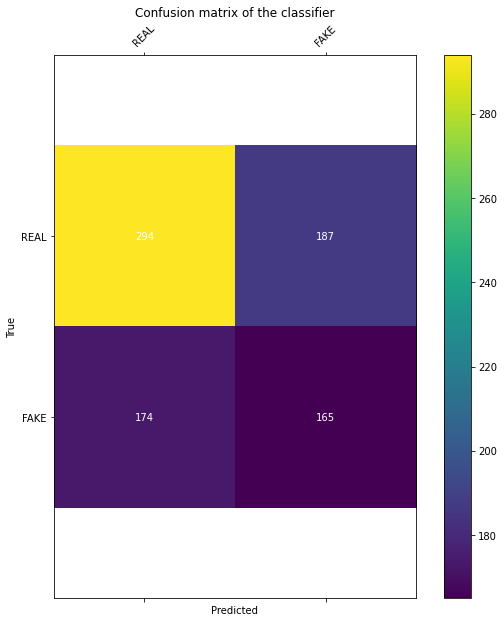

In [26]:
confusion_matrix_heatmap(valid_true,valid_pred,["REAL","FAKE"])

In [27]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'substantial part': 1, 'part deficit': 1, 'Bush tax': 1, 'cut helped': 1, 'helped create': 1, 'create substantial': 1, 'tax cut': 1, 'deficit .': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.577713
Recall: 0.582235
F Score:0.576481


In [28]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [29]:

#Reading rest of the features from the raw dataset
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path,encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            
            (label, text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts) = parse_data_line(line)
            raw_data.append((text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label))

#Changing the split and preprocess function to accommodate new features from the data
def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label) in raw_data[:num_training_samples]:
        l1=pre_process(text)
        p1=[pre_process_additional_feature(subject),pre_process_additional_feature(speaker),pre_process_additional_feature(speaker_job_title),pre_process_additional_feature(state_info),pre_process_additional_feature(party_affiliation),pre_process_additional_feature(context)]
        d1=to_feature_vector(l1) 
        d2=to_feature_vector_additional_feature(p1)
        for k,v in d2.items():
            d1[k]=v
        d1['total_barely_true_counts']=int(total_barely_true_counts)
        d1['total_false_counts']=int(total_false_counts)
        d1['total_half_true_counts']=int(total_half_true_counts)
        d1['total_mostly_true_counts']=int(total_mostly_true_counts)
        d1['total_pants_on_fire_counts']=int(total_pants_on_fire_counts)
        train_data.append((d1,label))
    for (text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label) in raw_data[num_training_samples:]:
        l1=pre_process(text)
        p1=[pre_process_additional_feature(subject),pre_process_additional_feature(speaker),pre_process_additional_feature(speaker_job_title),pre_process_additional_feature(state_info),pre_process_additional_feature(party_affiliation),pre_process_additional_feature(context)]
        l1.extend(p1)
        d1=to_feature_vector(l1)
        d2=to_feature_vector_additional_feature(p1)
        for k,v in d2.items():
            d1[k]=v
        d1['total_barely_true_counts']=int(total_barely_true_counts)
        d1['total_false_counts']=int(total_false_counts)
        d1['total_half_true_counts']=int(total_half_true_counts)
        d1['total_mostly_true_counts']=int(total_mostly_true_counts)
        d1['total_pants_on_fire_counts']=int(total_pants_on_fire_counts)
        test_data.append((d1,label))
    return (train_data, test_data)
    

In [30]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import re
import nltk
from nltk.util import trigrams
from nltk.stem.porter import *
stemmer = PorterStemmer()

#for improving the performance, stemming is not helpful as it dosent use context which adds addtional information.
#for s1 in str1:
#        x1+=stemmer.stem(s1)+" "

def pre_process(text):
    # Should return a list of tokens
    #removing punctuation
    txt1=re.sub('[^ a-zA-Z0-9$!?\'\"\.]','',text)#replacing all special characters except few $,?,!,',"
    
    #removing stop words
    tokens=txt1.split(' ')
    str1 = [w for w in tokens if not w.lower() in stop_words]
    x1=''
    #Not using stemming to convert words as stemming is used when context is not important
    #Lemmatization is used instead as context is important here.
    
    #Lemmatization of words
    for s1 in str1:
        x1+=lemmatizer.lemmatize(s1)+" "
    #Tokenising words into bigrams
    nltk_tokens = nltk.word_tokenize(x1)
    tokens=list(nltk.bigrams(nltk_tokens))
    tokens1=[]
    for t1 in tokens:
        tokens1.append(str(t1[0])+" "+str(t1[1]))
    return tokens1



In [31]:
def pre_process_additional_feature(text):
    text=re.sub('[^ a-zA-Z0-9]','',text)
    return text

In [32]:

def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    #label1 = [train_data, ]
    get_label = data_line[1]
    get_classification_label = convert_label(get_label)
    statement = data_line[2]
    subject=data_line[3]
    speaker=data_line[4]
    speaker_job_title=data_line[5]
    state_info=data_line[6]
    party_affiliation=data_line[7]
    total_barely_true_counts=data_line[8]
    total_false_counts=data_line[9]
    total_half_true_counts=data_line[10]
    total_mostly_true_counts=data_line[11]
    total_pants_on_fire_counts=data_line[12]
    context=data_line[13]
    # e.g. (label, statement)
    return (get_classification_label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts)

In [33]:
#Finally loading and splitting the dataset
raw_data = []          # the filtered data from the dataset file

data_file_path =r"fake_news.tsv"
load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')


#Changing the split and preprocess function to analyse new features from the data
train_data1=[]
test_data1=[]
def split_and_preprocess_data_additional_feature(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label) in raw_data[:num_training_samples]:
        train_data1.append((text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label))
    for (text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label) in raw_data[num_training_samples:]:
        test_data1.append((text,subject,speaker,speaker_job_title,state_info,party_affiliation,context,total_barely_true_counts,total_false_counts,total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,label))
    return (train_data1, test_data1)

split_and_preprocess_data_additional_feature(0.8)



Now 10241 rawData, 8192 trainData, 2049 testData
Preparing training and test data...


([('Says the Annies List political group supports third-trimester abortions on demand.',
   'abortion',
   'dwayne-bohac',
   'State representative',
   'Texas',
   'republican',
   'a mailer',
   '0',
   '1',
   '0',
   '0',
   '0',
   'FAKE'),
  ('When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
   'energy,history,job-accomplishments',
   'scott-surovell',
   'State delegate',
   'Virginia',
   'democrat',
   'a floor speech.',
   '0',
   '0',
   '1',
   '1',
   '0',
   'REAL'),
  ('Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
   'foreign-policy',
   'barack-obama',
   'President',
   'Illinois',
   'democrat',
   'Denver',
   '70',
   '71',
   '160',
   '163',
   '9',
   'REAL'),
  ('Health care reform legislation is likely to mandate free sex change surgeries.',
   'health-care',
   'blog-posting',
   '',
   '',
   'none',
   

In [34]:
import operator
subject1={}#subject dictionary
speaker1={}#speaker dictionary
speaker_job_tit1={}#speaker_job_title dictionary
for k in train_data1:
    label=k[7]
    if k[1] in subject1:
        subject1[k[1]]+=1
    else:
        subject1[k[1]]=1
    if k[2] in speaker1:
        speaker1[k[2]]+=1
    else:
        speaker1[k[2]]=1
    if k[3] in speaker_job_tit1:
        speaker_job_tit1[k[3]]+=1
    else:
        speaker_job_tit1[k[3]]=1
subject1=dict( sorted(subject1.items(), key=operator.itemgetter(1),reverse=True))
speaker1=dict( sorted(speaker1.items(), key=operator.itemgetter(1),reverse=True))
speaker_job_tit1=dict( sorted(speaker_job_tit1.items(), key=operator.itemgetter(1),reverse=True))

subjects=[]
for k,v in subject1.items():
    if v>3:
        subjects.append(pre_process_additional_feature(k))

speakers=[]
for k,v in speaker1.items():
    if v>3:
        speakers.append(pre_process_additional_feature(k))
        
speaker_job_tits=[]
for k,v in speaker_job_tit1.items():
    if v>3:
        speaker_job_tits.append(pre_process_additional_feature(k))

def to_feature_vector_additional_feature(tokens):
    feature_dict = {}
    keys = set(tokens)
    for key in keys:
        count = 0
        for token in tokens:
            if token in subjects or token in subjects or token in speaker_job_tits:  
                if key==token:
                    count = count*2
                else:
                    count=count+1
        feature_dict[key] = count
    return feature_dict


def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    feature_dict = {}
    keys = set(tokens)
    for key in keys:
        count = 0
        for token in tokens:
            if key==token:
                count = count+1
        feature_dict[key] = count
    return feature_dict

#Splitting and preprocessing data
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), sep='\n')


After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192


In [35]:
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    train_fold_list = []
    
    #Recording precision, recall, fscore and accuracy for 10 folds (i.e. each training and validation data combintation)
    precision_list = []
    recall_list = []
    fscore_list = []
    accuracy_list = []
    
    #Creating folds
    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        fold_limit = i+int(fold_size)
        train_fold_list.append(dataset[i:fold_limit])
    
    #Generating training and validation datasets from the training dataset
    for validation_index in range(len(train_fold_list)):
        validation_dataset = train_fold_list[validation_index]
        train_dataset = []
        for train_index in range(len(train_fold_list)):
            if(train_index == validation_index):
                continue
            else:
                train_dataset.extend(train_fold_list[train_index])
        
#         print("Fold {}".format(validation_index))
#         print("Train subset length = {}".format(len(train_data)))
#         print("Validation data length = {}".format(len(validation_data)))
#         print()
        
        #training and validating the model for each train and validation combination and finally getting
        #new precision, recall, fscore and accuracy
        train_val_classifier = train_classifier(train_dataset)
        valid_true = [v[1] for v in validation_dataset]
        valid_pred = predict_labels([v[0] for v in validation_dataset], train_val_classifier)
        cv_scores = precision_recall_fscore_support(valid_true, valid_pred, average='weighted')
        compare_results = [1 if vt==vp else 0 for vt,vp in zip(valid_true,valid_pred)]
        accuracy_score = sum(compare_results)/len(compare_results)
        
        #Appending the the results to the list
        precision_list.append(cv_scores[0])
        recall_list.append(cv_scores[1])
        fscore_list.append(cv_scores[2])
        accuracy_list.append(accuracy_score)
    
    #Computing the average for each score
    avg_precision = round((sum(precision_list)/len(precision_list))*100,2)
    avg_recall = round((sum(recall_list)/len(recall_list))*100,2)
    avg_fscore = round((sum(fscore_list)/len(fscore_list))*100,2)
    avg_accuracy = round((sum(accuracy_list)/len(accuracy_list))*100,2)
    
    cv_result = [avg_precision,avg_recall,avg_fscore,avg_accuracy]
    #Returning the list of avg scores
    print("\nAverage Precision: {}\nAverage Recall: {}\nAverage F-score: {}\nAverage Accuracy: {}".format(avg_precision,
                                                                                                       avg_recall,
                                                                                                       avg_fscore,
                                                                                                       avg_accuracy)) 

In [36]:
cross_validate(train_data, 10)


Fold start on items 0 - 820
Fold start on items 820 - 1640
Fold start on items 1640 - 2460
Fold start on items 2460 - 3280
Fold start on items 3280 - 4100
Fold start on items 4100 - 4920
Fold start on items 4920 - 5740
Fold start on items 5740 - 6560
Fold start on items 6560 - 7380
Fold start on items 7380 - 8200
Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Classifier...

Average Precision: 62.19
Average Recall: 62.52
Average F-score: 62.09
Average Accuracy: 62.52


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [37]:
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    #return cm

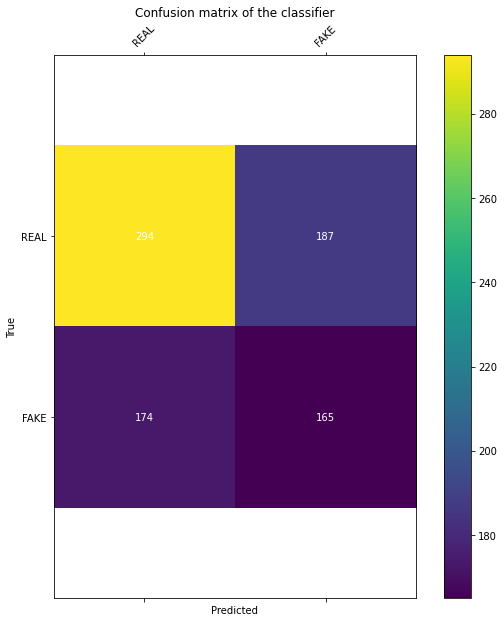

In [38]:
#confusion_matrix_heatmap(valid_true,valid_pred,["REAL","FAKE"])

In [39]:
from sklearn.metrics import precision_recall_fscore_support
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'denniskucinich': 1, 'democrat': 1, 'substantial part': 1, 'part deficit': 1, 'US representative': 0, 'Ohio': 1, 'a radio interview': 1, 'Bush tax': 1, 'bushadministrationdeficittaxes': 1, 'cut helped': 1, 'helped create': 1, 'create substantial': 1, 'tax cut': 1, 'deficit .': 1, 'total_barely_true_counts': 1, 'total_false_counts': 3, 'total_half_true_counts': 4, 'total_mostly_true_counts': 6, 'total_pants_on_fire_counts': 0}, 'REAL')
Training Classifier...
Done training!
Precision: 0.613920
Recall: 0.616886
F Score:0.609183


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
